# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
use_col = ['volumn']
data = pd.read_csv('../../TrafficData/2-Copy1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
sequence_length = 720
pred_len = 360

<AxesSubplot: >

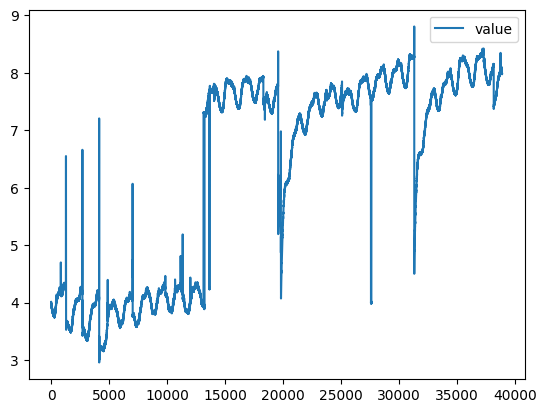

In [4]:
data.plot()

In [5]:
from torch import FloatTensor as FloatTensor

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [7]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [8]:
seed = 42

In [9]:
device = torch.device("cuda:0")

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360 # 1440
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [11]:
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [12]:
val_num = 1752

In [13]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_878885/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [14]:
train.tail(11)

,value
36949,8.268184
36950,8.285848
36951,8.293856
36952,8.291784
36953,8.270672
36954,8.286176
36955,8.264144
36956,8.277848
36957,8.274920
36958,8.282456


In [15]:
y_train.size()

torch.Size([35881, 360])

In [16]:
y_train[-1,-10:]

tensor([8.2858, 8.2939, 8.2918, 8.2707, 8.2862, 8.2641, 8.2778, 8.2749, 8.2825,
        8.2689], device='cuda:0')

In [17]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [18]:
x_train.size()

torch.Size([35881, 720])

In [19]:
x_val.size()

torch.Size([673, 720])

In [20]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [22]:
import copy

In [23]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
Epoch [21]

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
changed
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
to

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([41, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [24]:
output = outputs
label = labels

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

0.10268326

In [27]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

0.10268326

### validation set에 대해서 attribution 구하기

In [28]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [29]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [30]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [31]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

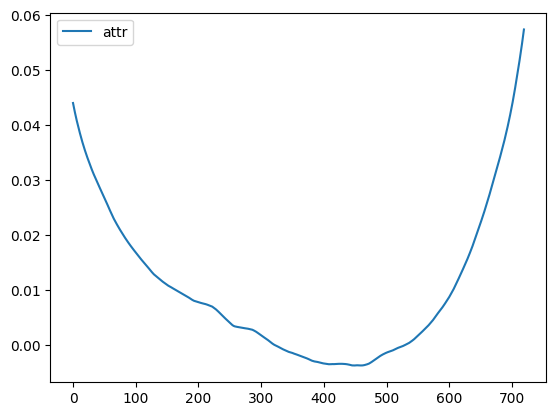

In [32]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

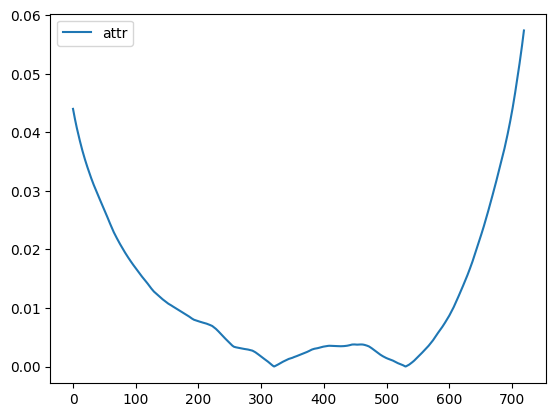

In [33]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [34]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
10,0.038949
11,0.038510
12,0.038083
13,0.037672
14,0.037252
...,...
688,0.037247
689,0.037722
690,0.038205
691,0.038688


In [35]:
outlier_max

attr    0.039241
dtype: float64

In [36]:
outlier_min

attr   -0.018971
dtype: float64

<AxesSubplot: >

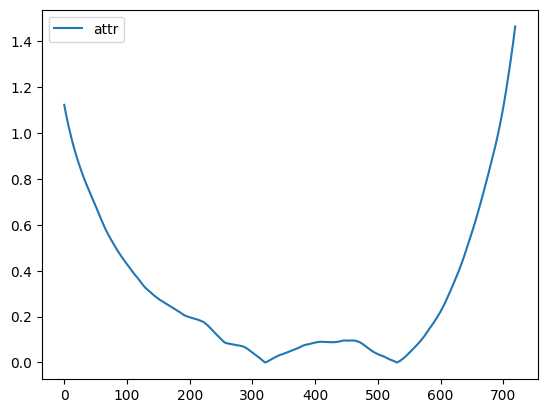

In [37]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [38]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.300394
std,0.325073
min,0.000000
25%,0.072542
50%,0.165813
75%,0.444165
max,1.464981


## 0과 1사이의 분포 확인하기

In [39]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
10,0.994136
11,0.982927
12,0.972038
13,0.961542
14,0.950807
...,...
688,0.950680
689,0.962823
690,0.975137
691,0.987490


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

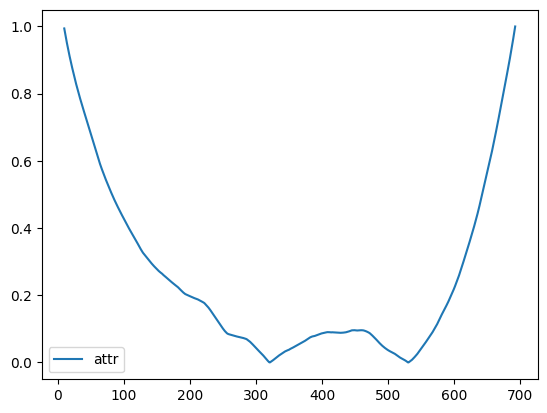

In [40]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

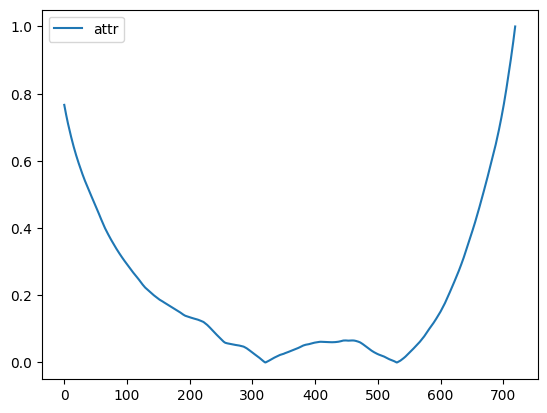

In [41]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [42]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [43]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


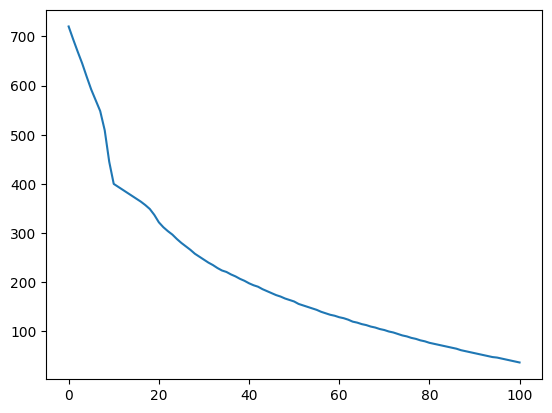

In [44]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [45]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:33.22748054194956
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:33.0825879782025
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:31.7170

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
13번째 모델 Training 완료 마지막 Epoch loss:28.639078639205312
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
23번째 모델 Training 완료 마지막 Epoch loss:27.92229978247328
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
32번째 모델 Training 완료 마지막 Epoch loss:27.04632944998509
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
42번째 모델 Training 완료 마지막 Epoch loss:26.6850115507866
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
51번째 모델 Training 완료 마지막 Epoch loss:26.132977430570918
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
52번째 모델 Training 완료 마지막 Epoch loss:26.277564740602806
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
61번째 모델 Training 완료 마지막 Epoch loss:25.620476618793475
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
71번째 모델 Training 완료 마지막 Epoch loss:25.528059869655202
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
80번째 모델 Training 완료 마지막 Epoch loss:24.97084660969389
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
90번째 모델 Training 완료 마지막 Epoch loss:23.800472492705318
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
99번째 모델 Training 완료 마지막 Epoch loss:22.80463951744833
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
100번째 모델 Training 완료 마지막 Epoch loss:22.69530131827306
changed


In [46]:
val_y # 다음 예측 타겟값

tensor([[7.5693, 7.5714, 7.5726,  ..., 7.9696, 8.0096, 8.0057],
        [7.5714, 7.5726, 7.5576,  ..., 8.0096, 8.0057, 7.9933],
        [7.5726, 7.5576, 7.5692,  ..., 8.0057, 7.9933, 7.9966],
        ...,
        [7.5802, 7.6185, 7.5775,  ..., 8.0106, 8.0131, 8.0106],
        [7.6185, 7.5775, 7.6007,  ..., 8.0131, 8.0106, 8.0160],
        [7.5775, 7.6007, 7.5653,  ..., 8.0106, 8.0160, 8.0369]],
       device='cuda:0')

In [47]:
val_x # 예측 하는 값

tensor([[7.8481, 7.8683, 7.8504,  ..., 7.5503, 7.5671, 7.5576],
        [7.8683, 7.8504, 7.8420,  ..., 7.5671, 7.5576, 7.5693],
        [7.8504, 7.8420, 7.8419,  ..., 7.5576, 7.5693, 7.5714],
        ...,
        [7.8246, 7.8456, 7.8203,  ..., 7.5762, 7.5724, 7.6008],
        [7.8456, 7.8203, 7.8221,  ..., 7.5724, 7.6008, 7.5802],
        [7.8203, 7.8221, 7.8158,  ..., 7.6008, 7.5802, 7.6185]],
       device='cuda:0')

In [48]:
result/68

0.0013438989134395823

In [49]:
val_x.size()

torch.Size([33, 720])

        out
0  0.065717


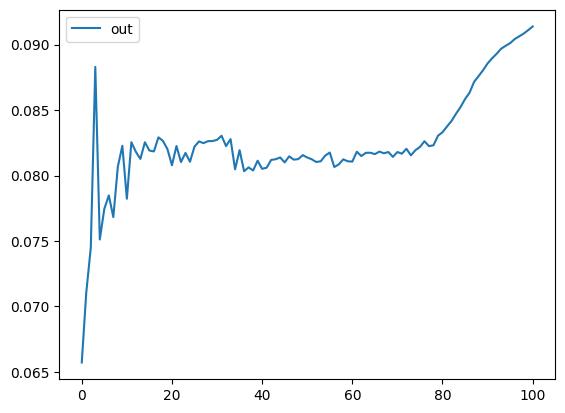

In [50]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [51]:
out_df 

,out
0,0.065717
1,0.071067
2,0.074493
3,0.088297
4,0.075115
...,...
96,0.090418
97,0.090628
98,0.090839
99,0.091104


        out
1  0.209487


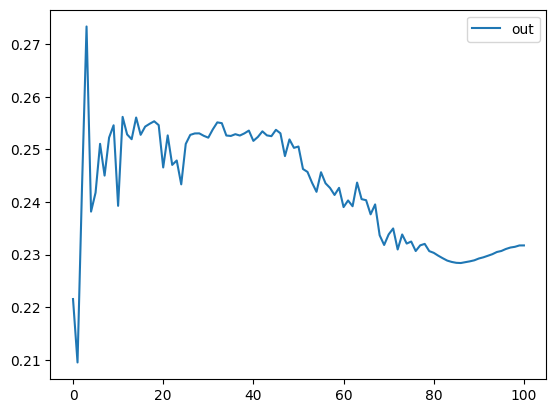

In [52]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [53]:
out_df 

,out
0,0.221548
1,0.209487
2,0.242996
3,0.273368
4,0.238174
...,...
96,0.231066
97,0.231340
98,0.231478
99,0.231737


        out
1  2.706444


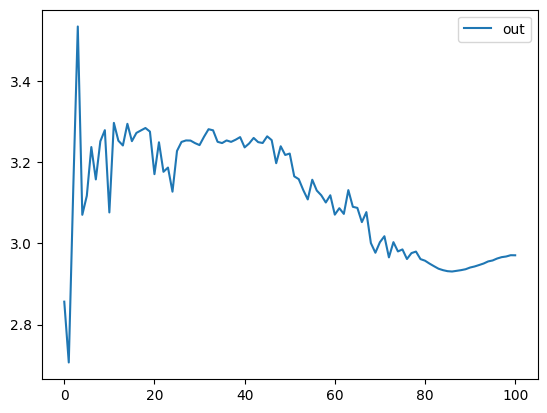

In [54]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [55]:
out_df 

,out
0,2.856485
1,2.706444
2,3.137355
3,3.535417
4,3.070809
...,...
96,2.962947
97,2.966308
98,2.967906
99,2.971081


        out
0  0.256354


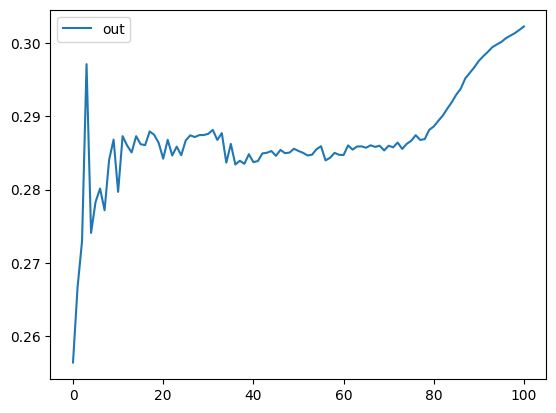

In [56]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [57]:
out_df 

,out
0,0.256354
1,0.266583
2,0.272933
3,0.297148
4,0.274070
...,...
96,0.300697
97,0.301045
98,0.301396
99,0.301835


In [58]:
attr_df.describe()

,attr
count,720.000000
mean,0.205050
std,0.221896
min,0.000000
25%,0.049518
50%,0.113184
75%,0.303188
max,1.000000
